# 2. Configuração do Ambiente

In [1]:
import os, re
import pathlib
import nrrd # pip install pynrrd
import matplotlib.pyplot as plt
import shutil 
import pandas as pd
import numpy as np
from collections import defaultdict
import SimpleITK as sitk
import random

# 3. Carregamento e Exploração dos Dados


In [2]:
imgs_path = pathlib.Path('./images')
for file_name in os.listdir(imgs_path):
    print(file_name)

1-Original_Anon_Dicom
2-Rescaled_256_NRRD
3-Segmentation_NRRD
Patients.xlsx


In [3]:
seg_folder = '3-Segmentation_NRRD'
seg_path = imgs_path / seg_folder

rescaled_folder = '2-Rescaled_256_NRRD'
rescaled_imgs = imgs_path / rescaled_folder

print(seg_path)
print(rescaled_imgs)

images\3-Segmentation_NRRD
images\2-Rescaled_256_NRRD


In [4]:
masks = {}
masks_header = {}

# 3.2.1 Explorando arquivos .nrrd


**Importando as mascaras do diretorio 3-Segmentation_NRRD junto com suas informacoes (header)**

In [5]:
for file_name in os.listdir(seg_path):
    if(file_name.endswith('.nrrd')):
        file_path = str(seg_path / file_name)
        start = file_path.index(file_name)
        end = file_path.index('.seg.nrrd')
        mask_id = file_path[start:end]
        masks[mask_id], masks_header[mask_id] = nrrd.read(file_path)

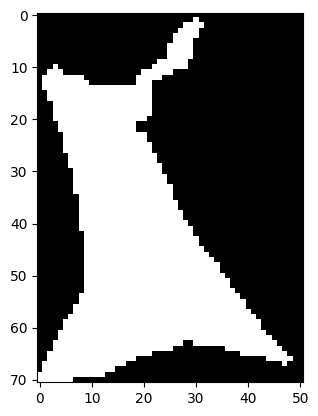

In [6]:
plt.imshow(masks['P2L1'][:,:,0], cmap='gray')

**Importando as imagens completas de ressonancia**



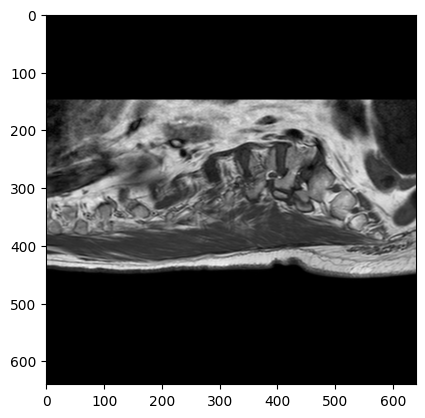

In [7]:
images = {}
for img_name in os.listdir(rescaled_imgs):
    if(img_name.endswith('.nrrd')):
        img_path = str(rescaled_imgs / img_name)
        start = img_path.index(img_name) 
        end = img_path.index('.nrrd')
        pacient_id = img_path[start:end]
        images[pacient_id] = nrrd.read(img_path)[0]

plt.imshow(images['P1'][:,:,1], cmap='gray')

# 3.2.3. Entendendo a Relação entre Máscaras e Imagens Originais


**Inspeciona a forma (dimensões) das imagens e máscaras**

In [8]:
print("Shape da máscara P1L1:", masks['P1L1'].shape)
print("Shape da imagem P1:", images['P1'].shape)

Shape da máscara P1L1: (70, 48, 5)
Shape da imagem P1: (640, 640, 14)


**Explora o cabeçalho da máscaras**

In [9]:
header_exemplo = masks_header['P1L1'] # ex paciente 1 vertebra l1
# Mostra todas as chaves disponíveis no cabeçalho
print("\nChaves disponíveis no header da máscara P1L1:")
for k in header_exemplo.keys():
    print(" -", k)


Chaves disponíveis no header da máscara P1L1:
 - type
 - dimension
 - space
 - sizes
 - space directions
 - kinds
 - encoding
 - space origin
 - measurement frame
 - Segment0_Color
 - Segment0_ColorAutoGenerated
 - Segment0_Extent
 - Segment0_ID
 - Segment0_Name
 - Segment0_NameAutoGenerated
 - Segment0_Tags
 - Segmentation_ContainedRepresentationNames
 - Segmentation_ConversionParameters
 - Segmentation_MasterRepresentation
 - Segmentation_ReferenceImageExtentOffset


**Pega a posição de referência (coordenada da mascara/pedaço em relacao a img original)**

In [10]:
offset = header_exemplo.get('Segmentation_ReferenceImageExtentOffset', 'N/A')
print("\nOffset de referência da máscara dentro da imagem original:", offset)


Offset de referência da máscara dentro da imagem original: 267 182 5


# 4. Organizando os Arquivos por Classe


**Cria a coluna "ClassNorm" coloca dataframe com dados do xlsx dos Pacientes**

In [11]:
patient_info   = imgs_path / 'Patients.xlsx'
df = pd.read_excel(patient_info)
CLASS_MAP = {'benign':'BENIGN', 'malignant':'MALIGNANT',
             'BENIGN':'BENIGN', 'MALIGNANT':'MALIGNANT'}
df['ClassNorm'] = df['Class'].map(CLASS_MAP)
df

,Id,Age at the exam,Gender,Class,Segmented Vertebra,ClassNorm
0,P1,67,F,benign,L1,BENIGN
1,P2,61,F,benign,L1/L3/L5,BENIGN
2,P3,65,M,benign,L1,BENIGN
3,P4,84,M,benign,L3,BENIGN
4,P5,78,F,benign,L1/L4,BENIGN
...,...,...,...,...,...,...
86,P87,72,F,malignant,L5,MALIGNANT
87,P88,68,M,malignant,L4,MALIGNANT
88,P89,77,M,malignant,L5,MALIGNANT
89,P90,55,M,malignant,L4,MALIGNANT


**Cria subpastas de saída (BENIGN, MALIGNANT)**



In [12]:
for cls in ['BENIGN', 'MALIGNANT']:
    (imgs_path/rescaled_folder/cls).mkdir(exist_ok=True, parents=True)
    (imgs_path/seg_folder/cls).mkdir(exist_ok=True, parents=True)

**Lê linha a linha do xlxs de Pacientes e move as benignas e malignas dos pacientes para sua pasta correspondente**

In [13]:
# Função auxiliar para copiar arquivos com segurança
def copy_if_exists(src_path: pathlib.Path, dst_dir: pathlib.Path):
    if src_path.exists():
        dst = dst_dir / src_path.name
        if not dst.exists():
            shutil.copy2(src_path, dst)
        return True
    return False

moved_images = moved_masks = 0

for _, row in df.iterrows():
    pid = str(row['Id']).strip()    # esperado 'P1', 'P2', ...
    cls = row['ClassNorm']
    if cls not in ('BENIGN','MALIGNANT'):
        print(f"[AVISO] Classe inválida para {pid}: {row['Class']}")
        continue

    cand_img = imgs_path / rescaled_folder / f"{pid}.nrrd"
    ok_img = copy_if_exists(cand_img, imgs_path/rescaled_folder/cls)
    moved_images += int(ok_img)

    # máscaras do paciente (em 3-Segmentation_NRRD): P{n}L{*}.seg.nrrd (ou .nrrd)
    for fn in os.listdir(imgs_path/seg_folder):
        if fn.lower().endswith('.nrrd') and fn.startswith(pid):
            ok_m = copy_if_exists((imgs_path/seg_folder/fn), (imgs_path/seg_folder/cls))
            moved_masks += int(ok_m)

print(f"Imagens copiadas: {moved_images}")
print(f"Máscaras copiadas: {moved_masks}")

Imagens copiadas: 91
Máscaras copiadas: 244


# 5. Processamento das Imagens e Extração de Patches


**Método 2 (SimpleITK + NRRD)**

In [14]:
# --------------------------------------
# Definição dos diretórios
# --------------------------------------
root_exams = imgs_path / rescaled_folder      # imagens NRRD redimensionadas (exames)
root_masks = imgs_path / seg_folder           # máscaras NRRD (segmentações)
output_root = imgs_path / "patches_output_nrrd"  # pasta de saída para os patches

classes = ["BENIGN", "MALIGNANT"]
output_root.mkdir(exist_ok=True, parents=True)
for cls in classes:
    (output_root / cls).mkdir(exist_ok=True, parents=True)

PATCH_SIZE = 150  # tamanho do patch 150x150

In [15]:
# --------------------------------------
#  Funções auxiliares
# --------------------------------------
def resample_mask_to_exam(mask, exam):
    """
    Redimensiona a máscara para alinhar exatamente com o exame.
    Isso garante que ambos tenham o mesmo tamanho e espaçamento.
    """
    return sitk.Resample(
        mask,
        exam.GetSize(),
        sitk.Transform(),
        sitk.sitkNearestNeighbor,
        exam.GetOrigin(),
        exam.GetSpacing(),
        exam.GetDirection(),
        0,
        mask.GetPixelID(),
    )


def best_slice_axis_index(mask_array):
    """
    Retorna o índice da fatia (slice) com a maior área de máscara.
    """
    areas = [np.sum(mask_array[:, :, i]) for i in range(mask_array.shape[2])]
    return int(np.argmax(areas))


def centered_window_from_centroid(center, window_size, shape):
    """
    Calcula os limites (x_min, x_max, y_min, y_max) de um recorte centrado no ponto informado.
    Garante que o recorte não saia dos limites da imagem.
    """
    half = window_size // 2
    x_center, y_center = int(center[0]), int(center[1])

    x_min = max(0, x_center - half)
    y_min = max(0, y_center - half)
    x_max = min(shape[0], x_center + half)
    y_max = min(shape[1], y_center + half)

    return x_min, x_max, y_min, y_max


def crop_with_padding(image_slice, mask_slice, window_size):
    """
    Corta uma região quadrada centrada na vértebra.
    Se o corte sair da borda, preenche com zeros (preto).
    """
    coords = np.argwhere(mask_slice > 0)
    if coords.size == 0:
        return None  # máscara vazia
    
    center = coords.mean(axis=0)
    x_min, x_max, y_min, y_max = centered_window_from_centroid(center, window_size, image_slice.shape)
    
    cropped = image_slice[x_min:x_max, y_min:y_max]
    
    # Adiciona padding se necessário
    h, w = cropped.shape
    pad_h = window_size - h
    pad_w = window_size - w
    if pad_h > 0 or pad_w > 0:
        cropped = np.pad(cropped, 
                         ((pad_h//2, pad_h - pad_h//2), (pad_w//2, pad_w - pad_w//2)),
                         mode='constant', constant_values=0)
    return cropped

In [16]:
# --------------------------------------
#  Loop para criar os patches
# ----
for cls in classes:
    exams_class_dir = root_exams / cls
    masks_class_dir = root_masks / cls
    output_class_dir = output_root / cls

    exams = sorted([f for f in exams_class_dir.glob("*.nrrd")])
    masks_files = sorted([f for f in masks_class_dir.glob("*.nrrd")])

    print(f"\nProcessando classe: {cls} ... Aguarde!")
    print(f"Total de exames encontrados: {len(exams)}")

    # Cria um dicionário paciente para máscaras correspondentes
    masks_by_patient = defaultdict(list)
    for mask_path in masks_files:
        stem = mask_path.stem.replace('.seg', '')
        m = re.search(r"P0*?(\d+)[_\-\. ]*L0*?(\d+)", stem, re.IGNORECASE)
        if m:
            pid, vertebra = m.groups()
            masks_by_patient[pid].append((int(vertebra), mask_path))
    for k in masks_by_patient.keys():
        masks_by_patient[k].sort(key=lambda x: x[0])

    # Processa exames por paciente
    for exam_path in exams:
        m_exam = re.search(r"P0*?(\d+)", exam_path.stem, re.IGNORECASE)
        pid = m_exam.group(1)
        exam = sitk.ReadImage(str(exam_path))
        exam_array = sitk.GetArrayFromImage(exam)
        for vertebra, mask_path in masks_by_patient[pid]:
            mask = sitk.ReadImage(str(mask_path))
            mask = resample_mask_to_exam(mask, exam)
            mask_array = sitk.GetArrayFromImage(mask)
            # Detecta eixo de fatias automaticamente
            slice_axis = np.argmin(mask_array.shape)
            areas = mask_array.sum(axis=tuple(i for i in range(mask_array.ndim) if i != slice_axis))
            slice_idx = int(np.argmax(areas))
            # Extrai a fatia correta
            if slice_axis == 0:
                img_slice = exam_array[slice_idx, :, :]
                mask_slice = mask_array[slice_idx, :, :]
            elif slice_axis == 1:
                img_slice = exam_array[:, slice_idx, :]
                mask_slice = mask_array[:, slice_idx, :]
            else:
                img_slice = exam_array[:, :, slice_idx]
                mask_slice = mask_array[:, :, slice_idx]

            masked_slice = img_slice * (mask_slice > 0)
            patch = crop_with_padding(masked_slice, mask_slice, PATCH_SIZE)
            patch = np.clip(patch, patch.min(), patch.max())
            range_ptp = np.ptp(patch)
            patch = (255 * (patch - patch.min()) / (range_ptp + 1e-5)).astype(np.uint8)

            out_name = f"P{pid}_L{vertebra}.png"
            out_path = output_class_dir / out_name
            sitk.WriteImage(sitk.GetImageFromArray(patch), str(out_path))

print(f"\n PRONTO!! \nPatches salvos em: {output_root}")


Processando classe: BENIGN ... Aguarde!
Total de exames encontrados: 47

Processando classe: MALIGNANT ... Aguarde!
Total de exames encontrados: 44

 PRONTO!! 
Patches salvos em: images\patches_output_nrrd


# 6. Divisão dos Datasets de Treino Teste e Validação


In [17]:
source_root = imgs_path / "patches_output_nrrd"  # pasta do passo 5
target_root = imgs_path / "dataset_final"        # pasta de saída final

splits = {
    "train": 0.7,
    "val": 0.15,
    "test": 0.15
}

for split in splits.keys():
    for cls in classes:
        (target_root / split / cls).mkdir(parents=True, exist_ok=True)

print("Estrutura de diretórios criada em:", target_root)

Estrutura de diretórios criada em: images\dataset_final


In [18]:
def get_patient_id(filename):
    """Extrai o identificador do paciente (Pxx) do nome do arquivo."""
    m = re.search(r"P(\d+)", filename)
    return int(m.group(1)) if m else None

patients_by_class = defaultdict(lambda: defaultdict(list))

for cls in classes:
    class_dir = source_root / cls
    for img_path in class_dir.glob("*.png"):
        pid = get_patient_id(img_path.name)
        if pid is not None:
            patients_by_class[cls][pid].append(img_path)

for cls in classes:
    all_patients = list(patients_by_class[cls].keys())
    random.shuffle(all_patients)

    n_total = len(all_patients)
    n_train = int(splits["train"] * n_total)
    n_val   = int(splits["val"]   * n_total)
    
    train_patients = all_patients[:n_train]
    val_patients   = all_patients[n_train:n_train + n_val]
    test_patients  = all_patients[n_train + n_val:]

    
    # Copia arquivos para as pastas finais
    for pid_list, split_name in [
        (train_patients, "train"),
        (val_patients, "val"),
        (test_patients, "test")
    ]:
        for pid in pid_list:
            for img_path in patients_by_class[cls][pid]:
                dst = target_root / split_name / cls / img_path.name
                shutil.copy2(img_path, dst)

    print(f"\nClasse: {cls}")
    print(f"  Treino: {len(train_patients)} pacientes")
    print(f"  Validação: {len(val_patients)} pacientes")
    print(f"  Teste: {len(test_patients)} pacientes")

print("\n Passo 6 concluído com sucesso!")
print(f"Dataset final criado em: {target_root}")


Classe: BENIGN
  Treino: 32 pacientes
  Validação: 7 pacientes
  Teste: 8 pacientes

Classe: MALIGNANT
  Treino: 30 pacientes
  Validação: 6 pacientes
  Teste: 8 pacientes

 Passo 6 concluído com sucesso!
Dataset final criado em: images\dataset_final


# 7. Modelagem e Classificação


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
base_dir = imgs_path / 'dataset_final'  # ou o nome da pasta onde ficaram as subpastas train/val/test

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 83 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
Found 25 images belonging to 2 classes.


In [22]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


C:\Users\paulo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 414ms/step - accuracy: 0.5422 - loss: 0.6996 - val_accuracy: 0.5909 - val_loss: 0.6801
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.4940 - loss: 0.7035 - val_accuracy: 0.6818 - val_loss: 0.6325
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - accuracy: 0.6506 - loss: 0.6426 - val_accuracy: 0.7273 - val_loss: 0.5892
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 0.6386 - loss: 0.6377 - val_accuracy: 0.6818 - val_loss: 0.5494
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.7108 - loss: 0.6426 - val_accuracy: 0.6818 - val_loss: 0.5944
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 0.5422 - loss: 0.7255 - val_accuracy: 0.6818 - val_loss: 0.5806
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.6145 - loss: 0.6428 - val_accuracy: 0.6818 - val_loss: 0.5871
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.6386 - loss: 0.6471 - val_accuracy: 0.6818 - val_loss:

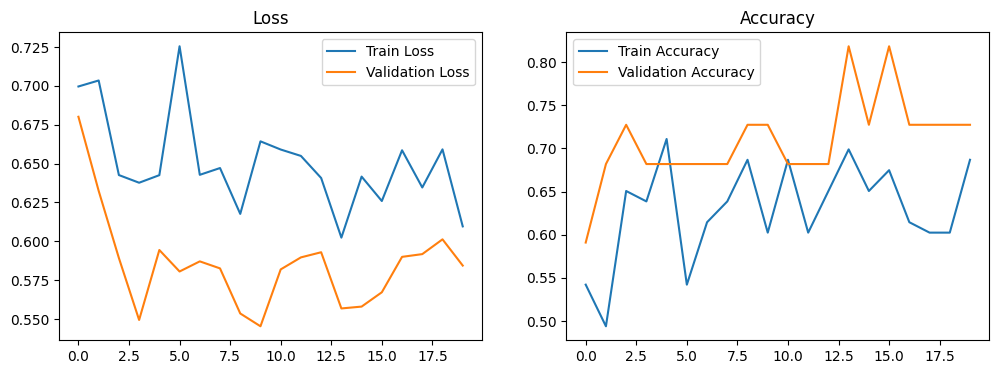

In [24]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


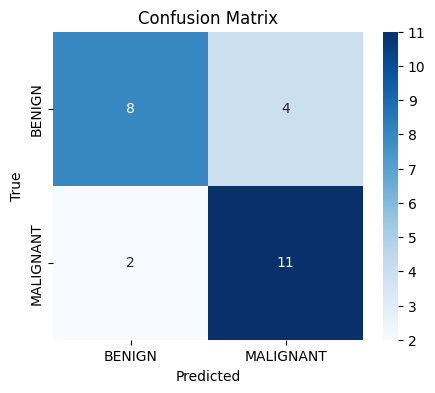

              precision    recall  f1-score   support

      BENIGN       0.80      0.67      0.73        12
   MALIGNANT       0.73      0.85      0.79        13

    accuracy                           0.76        25
   macro avg       0.77      0.76      0.76        25
weighted avg       0.77      0.76      0.76        25



In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict probabilities and convert to class labels
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).ravel()
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))

In [26]:
model.save('classificador_fcv.h5')